In [1]:
import os
import sys
import numpy as np
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pandas as pd
import re
from gensim.models import KeyedVectors
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import unicodedata

unable to import 'smart_open.gcs', disabling that module


This model aims to disapprove comments when they are advertising, negative comments or insulting.
It consists of a convolutional neural network for text classification built following this paper: 

Paper: https://arxiv.org/pdf/1408.5882.pdf

It makes use of pretrained word embeddings as well:

Aitor Almeida, & Aritz Bilbao. (2018). Spanish 3B words Word2Vec Embeddings (Version 1.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1410403

Can be downloaded from: https://zenodo.org/record/1410403#.XsSA8WhKg2w

*** The model is trained with comments written in spanish

# Global variables

In [2]:
TEST_SPLIT = 0.15
FILTER_SIZES = [2,3,4]
NUM_FILTERS = 256
DROPOUT = 0.5
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 5

# Stopwords and dicts

In [3]:
insurance_company_names = ['sura','rivadavia','allianz','hdi','pelayo','verti','ocaso','iati','meridional','sancor','prudential', 'iunigo']
transform_dict = {
    'k':'que',
    'q':'que',
    'xq': 'por que',
    'wsp':'whatsapp',
    'wasap':'whatsapp',
    'watsap':'whatsapp',
    'hdp': 'hijo de puta',
    'vergüenza' : 'verguenza',
    'imbesil': 'imbecil',
    'imbesiles': 'imbeciles'
}
non_important_words = ['seguro','seguros', 'hola', 'whatsapp']

# Load de data

In [4]:
approved_df = pd.read_csv('./data/all_approved.csv')
disapproved_df = pd.read_csv('./data/all_disapproved.csv')

# Preprocessing class

In [5]:
class text_preprocessor():
    
    def __init__(self, test_split, pad_with = 'max_len'):
        '''
        Pad with can be: 'max_lenght', 'avg_lenght' or int number
        ''' 
        if (pad_with not in ('max_len','avg_len')) and (type(pad_with) is not int):
            raise Exception("ERROR: Pad with must be 'max_lenght', 'avg_lenght' or int type")
        self.tokenizer = Tokenizer()
        self.test_split = test_split
        self.pad_with = pad_with
        self.pad_text_to = None
        self.nlp = spacy.load('es_core_news_sm', disable=['ner','parser'])
    
    def fit_transform(self, approved_df, disapproved_df):
        # Data Preparation
        x_text, y = self.make_dataset(approved_df, disapproved_df)

        # Build vocabulary
        if self.pad_with == 'max_len':
            max_text_lenght = max([len(x.split(" ")) for x in x_text])
            self.pad_text_to = max_text_lenght
        elif self.pad_with == 'avg_len':
            avg_text_lenght = int(np.mean([len(x.split(" ")) for x in x_text]))
            self.pad_text_to = avg_text_lenght
        elif type(self.pad_with) is int:
            self.pad_text_to = self.pad_with
        else:
            raise Exception("ERROR: Pad with must be 'max_lenght', 'avg_lenght' or int type")
        
        self.tokenizer.fit_on_texts(x_text)
        sequences =  self.tokenizer.texts_to_sequences(x_text)
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        print("Vocabulary Size : {}".format(vocab_size))
        x = pad_sequences(sequences, maxlen=self.pad_text_to) # Pad with 0.0 (default pad_sequences value)

        # Shuffle data
        np.random.seed(10)
        shuffle_indices = np.random.permutation(np.arange(len(y)))
        x_shuffled = x[shuffle_indices]
        y_shuffled = y[shuffle_indices]

        # Split train/test set
        test_sample_index = -1 * int(self.test_split * float(len(y)))
        x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
        y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

        del x, y, x_shuffled, y_shuffled

        print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
        return x_train, y_train, vocab_size, word_index, x_test, y_test
   
    def transform(self, text):
        stripped = [s.strip() for s in text]
        clean = [self.clean_str(sent) for sent in stripped]
        sequences = self.tokenizer.texts_to_sequences(clean)
        x = pad_sequences(sequences, maxlen=self.pad_text_to)
        return x
    
    def get_padded_text_len(self):
        if self.pad_text_to is not None:
            return self.pad_text_to
        else:
            raise Exception("ERROR: pad_text_to is not set. Must fit before get_padded_text_len")
        
    def clean_str(self,string):
        string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
        string = re.sub(r",", " , ", string)
        string = re.sub(r"!", " ! ", string)
        string = re.sub(r"\(", " \( ", string)
        string = re.sub(r"\)", " \) ", string)
        string = re.sub(r"\?", " \? ", string)
        string = re.sub(r"\s{2,}", " ", string) #2 spaces
        string = re.sub(r'[^\w\s]|(.)(?=\1)', '', string) #repeated chars such as hhholaaa = hola
        string = self.strip_accents(string)
        #replace words according the transform_dict
        string = ''.join(transform_dict[w.lower()] if w.lower() in transform_dict else w for w in re.split(r'(\W+)', string))
        #remove insurance company names and non important words
        stop_words = insurance_company_names + non_important_words
        string = ''.join(w.lower() if w.lower() not in stop_words else '' for w in re.split(r'(\W+)', string))
        
        doc = self.nlp(string)
        string = ' '.join([token.lemma_ for token in doc])
        
        return string.strip().lower()
    
    def strip_accents(self, text):

        try:
            text = unicode(text, 'utf-8')
        except NameError: # unicode is a default on python 3
            pass
        text = unicodedata.normalize('NFD', text)\
               .encode('ascii', 'ignore')\
               .decode("utf-8")
        return str(text)

    def make_dataset(self,approved_dataframe, disapproved_dataframe):
        # Load data from files
        approved_examples = approved_dataframe['text'].values
        approved_examples = [s.strip() for s in approved_examples]

        disapproved_examples = disapproved_dataframe['text'].values
        disapproved_examples = [s.strip() for s in disapproved_examples]
       
        x_text = approved_examples + disapproved_examples
        x_text = [self.clean_str(sent) for sent in x_text]
        # labels
        approved_labels = [[0, 1] for _ in approved_examples]
        disapproved_labels = [[1, 0] for _ in disapproved_examples]
        y = np.concatenate([approved_labels, disapproved_labels], 0)
        return [x_text, y]

In [6]:
processor = text_preprocessor(test_split = TEST_SPLIT, pad_with = 'max_len')

In [7]:
x_train, y_train, vocab_size, word_index, x_test, y_test = processor.fit_transform(approved_df, disapproved_df)

Vocabulary Size : 2766
Train/Test split: 1717/303


In [8]:
texts_fixed_len = processor.get_padded_text_len()

In [9]:
print("All texts will be padded with {} words".format(texts_fixed_len))

All texts will be padded with 99 words


# Pretrained word embeddings (spanish)

Aitor Almeida, & Aritz Bilbao. (2018). Spanish 3B words Word2Vec Embeddings (Version 1.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1410403

Can be downloaded from: https://zenodo.org/record/1410403#.XsSA8WhKg2w

### Load pretrained embeddings

In [10]:
wvec_fn = './embeddings/complete.kv'
wvecs = KeyedVectors.load(wvec_fn, mmap='r')
embeddings_vec_size = wvecs.vector_size
embeddings_vocab_size = len(wvecs.vocab)

In [11]:
embedding_matrix = np.zeros((len(word_index) + 1, embeddings_vec_size))
for word, i in word_index.items():
    try:
        embedding_vector = wvecs.get_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass # words that are not found in embeddings are filled with all 0

### Testing the embeddings

#### 1) Distance between words
Try embeddings looking at distances between words

In [12]:
wvecs.distances("automovil", ["vehiculo","casa"])

array([0.41484022, 0.8593671 ], dtype=float32)

We can se how distance between "automovil" and "casa" is bigger than distance between "automovil" and "vehiculo"

#### 2) Try to initialize an Embedding layer with pretrained embedding's weights

In [13]:
test_embedding_layer = Embedding(len(word_index) + 1,
                            embeddings_vec_size,
                            weights=[embedding_matrix],
                            input_length=texts_fixed_len,
                            trainable=False)

In [14]:
test_embeddings_model = Sequential([test_embedding_layer])

In [15]:
test_embeddings_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
test_embeddings_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 99, 400)           1106400   
Total params: 1,106,400
Trainable params: 0
Non-trainable params: 1,106,400
_________________________________________________________________


In [16]:
test_processed_text = processor.transform(['auto'])

In [17]:
wvecs.get_vector("auto")[:5]

memmap([-0.41554713, -0.1464285 ,  1.0438297 ,  2.5922477 , -0.75085735],
       dtype=float32)

In [18]:
test_result = test_embeddings_model.predict(test_processed_text)
test_result[0][texts_fixed_len-1][:5]

array([-0.41554713, -0.1464285 ,  1.0438297 ,  2.5922477 , -0.75085735],
      dtype=float32)

In [19]:
wvecs.get_vector("auto")[:5] == test_result[0][texts_fixed_len-1][:5]

array([ True,  True,  True,  True,  True])

# Convolutional Neural Network

#### Input and embedding layers

In [20]:
embedding_layer = Embedding(len(word_index) + 1,
                            embeddings_vec_size,
                            weights=[embedding_matrix],
                            input_length=texts_fixed_len,
                            trainable=False)

In [21]:
inputs = Input(shape=(texts_fixed_len,), dtype='int32')

In [22]:
embedding = embedding_layer(inputs)

The embedding layer is initialized with the embedding_matrix values.
It's shape is: (None, texts_fixed_len, 400) where 400 is the size of the embedding vectors.

In [23]:
reshape = Reshape((texts_fixed_len,embeddings_vec_size,1))(embedding)

We need to reshape because the conv layer expects an input of shape: (None, texts_fixed_len, 400, 1)

(this is for 1 channel)

#### Convolutional and max-pooling layers

A conv2D layer followed by a MaxPool2D layer will be added to the model for each filter size.
 - pading = "valid" -> It means that it wont apply any padding to the edges.

In [24]:
concat = []
for filter_size in FILTER_SIZES:
    conv_layer = Conv2D(NUM_FILTERS, 
                        kernel_size=(filter_size, embeddings_vec_size),
                        padding='valid', 
                        kernel_initializer='normal', 
                        activation='relu')(reshape)
    pooling_layer = MaxPool2D(pool_size=(texts_fixed_len - filter_size + 1, 1),
                               strides=(1,1),
                               padding='valid')(conv_layer)
    concat.append(pooling_layer)

#### Concat and flatten tensors

In [25]:
concatenate = Concatenate(axis=1)(concat)
flatten = Flatten()(concatenate)

#### Dropout regularization

In [26]:
dropout = Dropout(DROPOUT)(flatten)

#### Output

In [27]:
output = Dense(units=2, activation='softmax')(dropout)

#### Compile model

In [28]:
model = Model(inputs=inputs, outputs=output)

In [29]:
checkpoint = ModelCheckpoint('reviews-text-cnn.hdf5',
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto')

adam = Adam(lr=LEARNING_RATE)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

#### Model summary

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 99, 400)      1106400     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 99, 400, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 1, 256)   205056      reshape[0][0]                    
______________________________________________________________________________________________

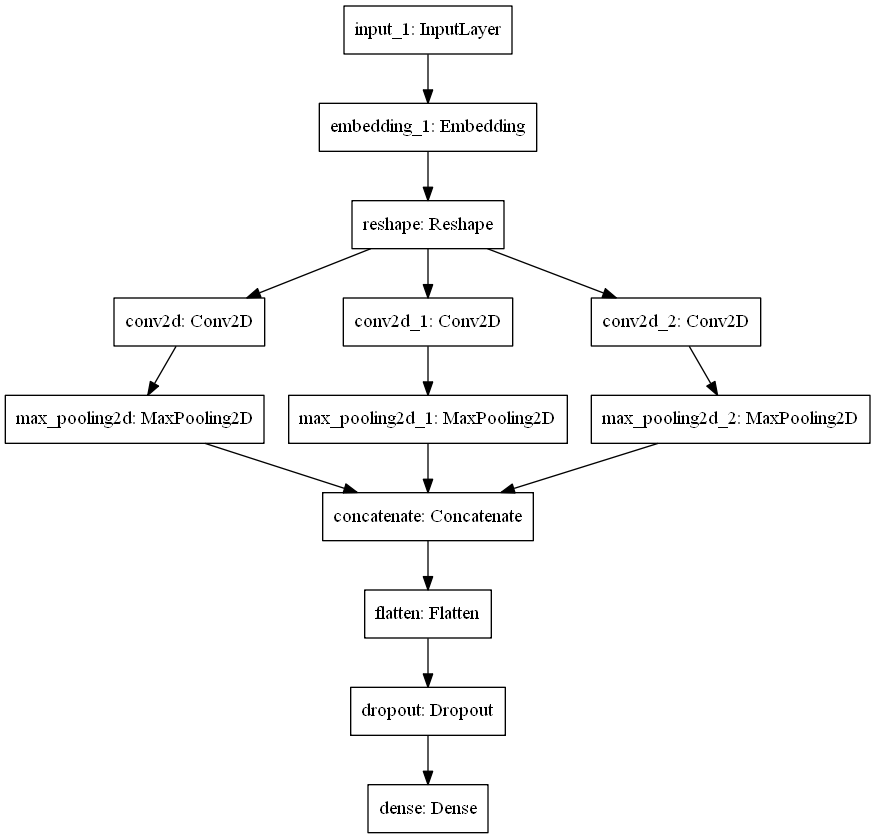

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn.png')

#### Train the model

In [32]:
%%time
model.fit(x_train, y_train, 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, 
          verbose=1, 
          callbacks=[checkpoint, tensorflow.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE)], 
          validation_data=(x_test, y_test))

Train on 1717 samples, validate on 303 samples
Epoch 1/25
1717/1717 [==============================] - 14s 8ms/sample - loss: 2.8563 - accuracy: 0.7362 - val_loss: 0.6459 - val_accuracy: 0.8977
Epoch 2/25
1717/1717 [==============================] - 10s 6ms/sample - loss: 0.8426 - accuracy: 0.8695 - val_loss: 0.4141 - val_accuracy: 0.9109
Epoch 3/25
1717/1717 [==============================] - 9s 5ms/sample - loss: 0.5187 - accuracy: 0.9086 - val_loss: 0.5790 - val_accuracy: 0.8944
Epoch 4/25
1717/1717 [==============================] - 11s 6ms/sample - loss: 0.3819 - accuracy: 0.9406 - val_loss: 0.5418 - val_accuracy: 0.9142
Epoch 5/25
1717/1717 [==============================] - 12s 7ms/sample - loss: 0.2283 - accuracy: 0.9540 - val_loss: 0.3575 - val_accuracy: 0.9406
Epoch 6/25
1717/1717 [==============================] - 10s 6ms/sample - loss: 0.1550 - accuracy: 0.9656 - val_loss: 0.4879 - val_accuracy: 0.9340
Epoch 7/25
1717/1717 [==============================] - 9s 6ms/sample - 

# Evaluate

In [33]:
from sklearn.model_selection import KFold
 
n_split=3

X = np.vstack([x_train, x_test])
Y = np.vstack([y_train, y_test])

n_fold = 0
for train_index,test_index in KFold(n_split).split(x_train):
    k_x_train,k_x_test=X[train_index],X[test_index]
    k_y_train,k_y_test=Y[train_index],Y[test_index]
  
    eval_model= tensorflow.keras.models.clone_model(model)
    eval_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    eval_model.fit(k_x_train, k_y_train,epochs=EPOCHS,  verbose = 0)
  
    print(f'Model evaluation for fold {n_fold}',eval_model.evaluate(k_x_test,k_y_test))
    n_fold += 1

573/573 [==============================] - 1s 3ms/sample - loss: 0.1684 - accuracy: 0.92841s - loss: 0
Model evaluation for fold 0 [0.16837067808468303, 0.92844677]
572/572 [==============================] - 1s 2ms/sample - loss: 0.1555 - accuracy: 0.9406
Model evaluation for fold 1 [0.1554627038434252, 0.94055945]
572/572 [==============================] - 1s 2ms/sample - loss: 0.3098 - accuracy: 0.9091
Model evaluation for fold 2 [0.30984705358326853, 0.90909094]


In [34]:
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

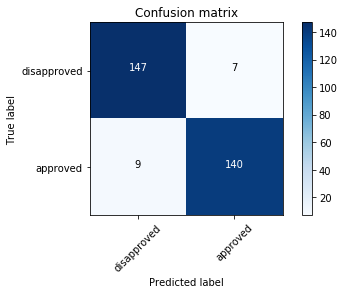

In [35]:
from sklearn.metrics import confusion_matrix

val_preds = model.predict(x_test)
val_preds = np.where(val_preds > 0.5, 1, 0)

conf_matrix = confusion_matrix(y_test[:,1], val_preds[:,1])
plot_confusion_matrix(conf_matrix, ["disapproved", "approved"])

In [36]:
from sklearn.metrics import roc_auc_score, classification_report
print(f"ROC AUC SCORE: {roc_auc_score(y_test[:,1], val_preds[:,1])}")
print("\n"*2+"Classification report: \n")
print(classification_report(y_test[:,1], val_preds[:,1]))

ROC AUC SCORE: 0.9470713849908481


Classification report: 

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       154
           1       0.95      0.94      0.95       149

    accuracy                           0.95       303
   macro avg       0.95      0.95      0.95       303
weighted avg       0.95      0.95      0.95       303



# Some tests

In [43]:
positive = processor.transform(['Buenas experiencias con esta empresa. La recomiendo'])
positive_preds = model.predict(positive)

print("Disapproved: {}".format(round(positive_preds[0][0])))
print("Approved: {}".format(round(positive_preds[0][1])))

Disapproved: 0.0
Approved: 1.0


In [38]:
positive_2 = processor.transform(['es un buen post. Muy interesante e informativo.'])
positive_2_preds = model.predict(positive_2)

print("Disapproved: {}".format(round(positive_2_preds[0][0])))
print("Approved: {}".format(round(positive_2_preds[0][1])))

Disapproved: 0.0
Approved: 1.0


In [39]:
negative = processor.transform(['desastroso nadie me atiende el telefono'])
negative_preds = model.predict(negative)

print("Disapproved: {}".format(round(negative_preds[0][0])))
print("Approved: {}".format(round(negative_preds[0][1])))

Disapproved: 1.0
Approved: 0.0


In [40]:
light_negative = processor.transform(['La verdad que este seguro deja mucho que desear.'])
light_negative_preds = model.predict(light_negative)

print("Disapproved: {}".format(round(light_negative_preds[0][0])))
print("Approved: {}".format(round(light_negative_preds[0][1])))

Disapproved: 1.0
Approved: 0.0


In [41]:
insult = processor.transform(['Me parece muy buen articulo la verdad que me gusto lo recomiendo. Hijos de puta'])
insult_preds = model.predict(insult)

print("Disapproved: {}".format(round(insult_preds[0][0])))
print("Approved: {}".format(round(insult_preds[0][1])))

Disapproved: 1.0
Approved: 0.0


In [42]:
advertising = processor.transform(['ESTAS BUSCANDO UN SEGURO PARA TU AUTO? EN CUCHUFLAI SEGUROS PODEMOS AYUDARTE. CONTACTATE CONMIGO VIA WHATSAPP A 35120382'])
advertising_preds = model.predict(advertising)

print("Disapproved: {}".format(round(advertising_preds[0][0])))
print("Approved: {}".format(round(advertising_preds[0][1])))

Disapproved: 1.0
Approved: 0.0
